In [58]:
import pandas as pd
import random 
import numpy as np
import re

In [59]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [62]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [63]:
#Função elaborada para criação de colunas de data e estoque dos produtos,

def data(n, seed):

    datas = []
    
    random.seed(seed)
    for i in range(n):
        dia_maximo = 30
        dia_minimo = 1
        mes_maximo = 12
        mes_minimo = 1
        
        dia = int(round(random.random() * (dia_maximo - dia_minimo) + dia_minimo, 0))
        mes = int(round(random.random() * (mes_maximo - mes_minimo) + mes_minimo, 0))
        
        datas.append(str(dia)+'-'+str(mes)+'-2018')
        
    return datas

def estoque(n, seed):

    np.random.seed(seed)
    mu, sigma = 1, 20
    s = np.random.normal(mu, sigma, n)
    s[s < 0] = s[s < 0] * -0.5
    s = s.astype(int)
    s[s < 1] = 1
    
    return s

train['date']  = data(n = train.shape[0], seed = 10)
train['stock'] = estoque(n = train.shape[0], seed = 10)

test['date']  = data(n = test.shape[0], seed = 15)
test['stock'] = estoque(n = test.shape[0], seed = 15)

train.drop('train_id', axis=1, inplace=True)


In [64]:
#Função criada para dividirmos as categorias em 3 colunas.

from numpy.lib.function_base import delete
rotulos = [i for i in train['category_name'].fillna('missing/missing/missing').str.split("/")]
rotulos

gen_cat = []
sub1_cat = []
sub2_cat = []

for i in range(0,len(rotulos)):
  gen_cat.append(rotulos[i][0])
  sub1_cat.append(rotulos[i][1])
  sub2_cat.append(rotulos[i][2])

train['gen_cat'] = gen_cat
train['sub1_cat'] = sub1_cat
train['sub2_cat'] = sub2_cat

del gen_cat
del sub1_cat
del sub2_cat

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482531 non-null  object 
 7   date               1482535 non-null  object 
 8   stock              1482535 non-null  int32  
 9   gen_cat            1482535 non-null  object 
 10  sub1_cat           1482535 non-null  object 
 11  sub2_cat           1482535 non-null  object 
dtypes: float64(1), int32(1), int64(2), object(8)
memory usage: 130.1+ MB


In [66]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,date,stock,gen_cat,sub1_cat,sub2_cat
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,18-6-2018,27,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,18-3-2018,15,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,25-10-2018,14,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,20-3-2018,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,16-5-2018,13,Women,Jewelry,Necklaces


In [67]:
train.describe()

,item_condition_id,price,shipping,stock
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,1.907380e+00,2.673752e+01,4.472744e-01,1.178544e+01
std,9.031586e-01,3.858607e+01,4.972124e-01,1.056072e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+01,0.000000e+00,4.000000e+00
50%,2.000000e+00,1.700000e+01,0.000000e+00,9.000000e+00
75%,3.000000e+00,2.900000e+01,1.000000e+00,1.700000e+01
max,5.000000e+00,2.009000e+03,1.000000e+00,9.500000e+01


In [68]:
train.isnull().sum()

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
date                      0
stock                     0
gen_cat                   0
sub1_cat                  0
sub2_cat                  0
dtype: int64

In [69]:
train.duplicated().sum()

0

In [70]:
#Para um primeiro momento, elaborando um baseline, serão adiconados "missing" em valores nulos.

train["brand_name"].fillna("missing", inplace=True)
train["category_name"].fillna("missing", inplace=True)
train["item_description "].fillna("missing", inplace=True)

In [72]:
train.isnull().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
date                 0
stock                0
gen_cat              0
sub1_cat             0
sub2_cat             0
dtype: int64

array([[<AxesSubplot:title={'center':'item_condition_id'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'shipping'}>,
        <AxesSubplot:title={'center':'stock'}>]], dtype=object)

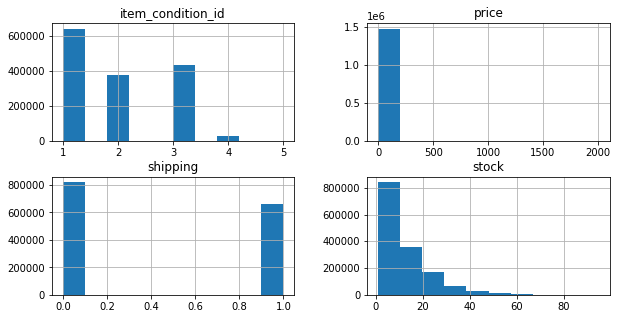

In [73]:
train.hist(figsize=(10,5))

In [74]:
X = train.drop("price", axis = 1)
y = train["price"]

In [75]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=10) #Divisão em 80/20

<AxesSubplot:>

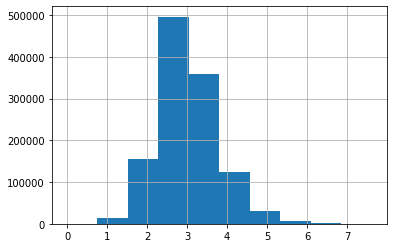

In [76]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
yval =  np.log1p(yval)
ytrain.hist()

In [77]:
Xtrain.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,date,stock,gen_cat,sub1_cat,sub2_cat
494714,Victoria's Secret IPhone 6/6s Case,1,"Electronics/Cell Phones & Accessories/Cases, C...",missing,1,New in packaging. Gold glitter leopard print. ...,30-9-2018,3,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins"
1336732,Toddler size 7 boys velcro top shoes,3,Kids/Boys 2T-5T/Shoes,missing,1,In great used condition. Size 7 grey velcro bo...,22-3-2018,22,Kids,Boys 2T-5T,Shoes
1162122,GAP Thermal Pullover - Striped,2,"Men/Sweats & Hoodies/Sweatshirt, Pullover",Gap,1,Dark blue with white stripes. Made of that str...,14-1-2018,12,Men,Sweats & Hoodies,"Sweatshirt, Pullover"
1417690,Jordan XI 11 Retro Wool size 9,1,Men/Shoes/Athletic,Air Jordan,1,Brand New!!! without box size us 9 (42.5),21-8-2018,2,Men,Shoes,Athletic
913521,YSL Foundation,3,Beauty/Makeup/Face,Yves Saint Laurent,1,Touche eclat foundation. Shade B50 has 75% lef...,1-5-2018,18,Beauty,Makeup,Face


In [78]:
Xval.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,date,stock,gen_cat,sub1_cat,sub2_cat
774893,Mario and luigi,1,Kids/Toys/Dress Up & Pretend Play,missing,1,Girls costumes. I can separate or i will sell ...,25-7-2018,1,Kids,Toys,Dress Up & Pretend Play
431736,Air Jordan Baron 9,3,Men/Shoes/Athletic,Jordan,0,Sz 10.5 Good preowned condition Includes origi...,30-7-2018,4,Men,Shoes,Athletic
693618,Pokémon Sun Moon Ruby Sapphire 3DS,3,Electronics/Video Games & Consoles/Games,Nintendo,0,Pokémon Moon Nintendo 3DS Pokémon Sun Nintendo...,13-6-2018,9,Electronics,Video Games & Consoles,Games
1453767,11 lows,2,Men/Shoes/Athletic,Jordan,0,Excellent condition,21-1-2018,8,Men,Shoes,Athletic
1180239,Princess house,1,Home/Kitchen & Dining/Kitchen Utensils & Gadgets,missing,0,Drying mat Microfiber towel Sponge Set of 3,15-7-2018,3,Home,Kitchen & Dining,Kitchen Utensils & Gadgets


In [79]:
#Objeto para transformações de pré processamento

ColumnTransformer = make_column_transformer(
    (OneHotEncoder(sparse=False),["shipping","gen_cat","sub1_cat","sub2_cat"]), #transformando categoricas em colunas separadas("dummy")
    (TfidfVectorizer(),"name" ), #vetorizando a coluna de texto "name"
    (TfidfVectorizer(),"item_description" ), #vetorizando a coluna de texto "item_description"
    remainder="passthrough", #Pulando colunas que não terão transformações
    sparse_threshold=0        # Ajustando a densidade da matrix
)


In [80]:

rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
Lr = LinearRegression()

In [81]:
pipe = make_pipeline(ColumnTransformer, Lr) #pipeline para regressão linear

In [82]:
model = pipe.fit(Xtrain,ytrain)

MemoryError: Unable to allocate 828. GiB for an array with shape (1186024, 93673) and data type float64

Primeira elaboração do pipeline com problemas de memórias, vamos fazer mais pré processamentos e limpezas para mitigar.